Import

In [1]:
import os
import json
import random
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

from transformers import (
    T5ForConditionalGeneration,
    T5Config,
    PreTrainedTokenizerFast,
    get_linear_schedule_with_warmup
)
from transformers.modeling_outputs import BaseModelOutput

from tokenizers import Tokenizer
from tokenizers import models as tokenizers_models, pre_tokenizers

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

2025-05-07 07:26:20.407077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746602780.593099      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746602780.645229      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# --- Tokenizer ---
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
def build_custom_tokenizer(vocab_path: str, max_len: int = 32) -> PreTrainedTokenizerFast:
    with open(vocab_path, 'r', encoding='utf-8') as f:
        idx2token = json.load(f)
    token2idx = {tok: int(idx) for idx, tok in idx2token.items()}
    wordlevel = tokenizers_models.WordLevel(vocab=token2idx, unk_token="<unk>")
    tok = Tokenizer(wordlevel)
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tok,
        bos_token="<s>",
        eos_token="</s>",
        unk_token="<unk>",
        pad_token="<pad>"
    )
    tokenizer.model_max_length = max_len
    return tokenizer

# ---------- Dataset ----------
class ImageCaptionDataset(Dataset):
    def __init__(self, image_dir: str, captions_file: str, tokenizer, transform):
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform
        with open(captions_file, 'r', encoding='utf-8') as f:
            self.pairs = [l.strip().split('\t') for l in f if l.strip()]
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        img_name, caption = self.pairs[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        img = self.transform(img)
        enc = self.tokenizer(
            caption,
            padding='max_length',
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors='pt'
        )
        return img, enc.input_ids.squeeze(0), enc.attention_mask.squeeze(0), caption

# ---------- Encoder ----------
class CNNEncoder(nn.Module):
    def __init__(self, embed_dim: int):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters(): param.requires_grad = False
        for layer_name in ['layer3', 'layer4']:
            for param in getattr(resnet, layer_name).parameters(): param.requires_grad = True
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        self.norm = nn.LayerNorm(embed_dim)
    def forward(self, x):
        feats = self.backbone(x).squeeze(-1).squeeze(-1)
        return self.norm(self.fc(feats))

# ---------- Model ----------
class CaptionModel(nn.Module):
    def __init__(self, mode: str, tokenizer, pretrained_model_name: str = None, custom_config: T5Config = None):
        super().__init__()
        embed_dim = custom_config.d_model if custom_config else 768
        self.encoder = CNNEncoder(embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        if mode == 'scratch':
            assert custom_config is not None
            self.decoder = T5ForConditionalGeneration(config=custom_config)
        else:
            self.decoder = T5ForConditionalGeneration.from_pretrained(pretrained_model_name)
            self.decoder.resize_token_embeddings(len(tokenizer.get_vocab()))
        self.tokenizer = tokenizer
        self.infer_transform = transforms.Compose([
            transforms.Resize((224,224)), transforms.ToTensor()
        ])
    def forward(self, images, input_ids, attention_mask, labels=None):
        feats = self.encoder(images)
        enc_proj = self.proj(feats).unsqueeze(1)
        return self.decoder(
            encoder_outputs=(enc_proj,),
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            return_dict=True
        )
    def generate_caption(self, image_input, max_length=32, num_beams=5):
        device = next(self.encoder.parameters()).device
        self.encoder.eval()
        self.decoder.eval()

        # Load image
        if isinstance(image_input, str):
            img = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, torch.Tensor):
            img = transforms.ToPILImage()(image_input.squeeze(0).cpu())
        else:
            img = image_input.convert('RGB')

        # Preprocess + forward
        x = self.infer_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feats = self.encoder(x)
            enc_out = self.proj(feats).unsqueeze(1)
            encoder_outputs = BaseModelOutput(last_hidden_state=enc_out)

            start = self.decoder.config.decoder_start_token_id
            decoder_input_ids = torch.tensor([[start]], device=device)

            output_ids = self.decoder.generate(
                decoder_input_ids=decoder_input_ids,
                encoder_outputs=encoder_outputs,
                max_length=max_length,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
                num_beams=num_beams,
                early_stopping=True
            )

        return self.tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

    def generate_captions_for_folder(
        self,
        folder_path: str,
        output_dir: str = "/kaggle/working",
        output_name: str = None,
        max_length: int = 32,
        num_beams: int = 5
    ):
        """
        Sinh caption cho tất cả ảnh trong folder và ghi ra file output_name hoặc cap_<foldername>.txt.
        Mỗi dòng: <filename>\\t<caption>.
        """
        os.makedirs(output_dir, exist_ok=True)
        foldername = os.path.basename(folder_path.rstrip(os.sep))

        # Xác định tên file đầu ra
        if output_name:
            base, ext = os.path.splitext(output_name)
            ext = ext or ".txt"
            filename = base + ext
        else:
            filename = f"cap_{foldername}.txt"

        out_path = os.path.join(output_dir, filename)

        # Lấy danh sách ảnh
        files = sorted(
            f for f in os.listdir(folder_path)
            if f.lower().endswith(("jpg", "jpeg", "png"))
        )

        # Sinh caption và ghi file
        with open(out_path, "w", encoding="utf-8") as fw:
            for fname in files:
                img_path = os.path.join(folder_path, fname)
                caption = self.generate_caption(
                    img_path,
                    max_length=max_length,
                    num_beams=num_beams
                )
                fw.write(f"{fname}\t{caption}\n")

        print(f"Saved captions to {out_path}")
        return out_path

# ---------- Training with Checkpoint ----------
def train_and_validate(
    model,
    train_dl,
    val_dl,
    device,
    mode: str = "finetune",
    output_dir: str = ".",
    epochs: int = 5,
    lr: float = 1e-4,
    patience: int = 3
):
    os.makedirs(output_dir, exist_ok=True)
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    total_steps = epochs * len(train_dl)
    warmup = int(0.1 * total_steps)
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup, total_steps)
    best_loss = float('inf'); best_state = None; no_improve = 0
    ckpt_path = os.path.join(output_dir, f"best_{mode}_checkpoint.pt")
    model.to(device)
    for ep in range(1, epochs+1):
        model.train()
        for imgs, ids, masks, _ in tqdm(train_dl, desc=f"Train Epoch {ep}/{epochs}"):
            imgs, ids, masks = imgs.to(device), ids.to(device), masks.to(device)
            loss = model(imgs, ids, masks, labels=ids).loss
            optimizer.zero_grad(); loss.backward(); optimizer.step(); scheduler.step()
        if val_dl:
            model.eval(); val_loss=0; count=0
            with torch.no_grad():
                for imgs, ids, masks, _ in val_dl:
                    imgs, ids, masks = imgs.to(device), ids.to(device), masks.to(device)
                    val_loss += model(imgs, ids, masks, labels=ids).loss.item(); count+=1
            avg_val_loss = val_loss/count
            print(f"Epoch {ep} Validation Loss: {avg_val_loss:.4f}")
        else:
            avg_val_loss = float('inf')
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss; best_state = model.state_dict(); no_improve=0
            torch.save(best_state, ckpt_path)
            print(f"-- Saved best checkpoint at {ckpt_path} (loss: {best_loss:.4f}) --")
        else:
            no_improve+=1; print(f"-- No improvement for {no_improve} epoch(s) --")
            if no_improve>=patience: print(f"Early stopping after {patience} epochs."); break
    if best_state: model.load_state_dict(best_state)
    return model
    
def show_first_test_images_and_caption(model, test_images_dir: str, n: int = 10, max_length: int = 32):
    # Hiển thị n ảnh đầu tiên (theo tên file sắp xếp) cùng caption
    files = sorted([f for f in os.listdir(test_images_dir) if f.lower().endswith(('jpg','jpeg','png'))])
    for fname in files[:n]:
        path = os.path.join(test_images_dir, fname)
        img = Image.open(path).convert('RGB')
        caption = model.generate_caption(path, max_length=max_length)
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption)
        plt.show()
        
# ---------- Pipeline ----------
def run_pipeline(
    mode,
    vocab_path,
    train_imgs,
    train_caps,
    val_imgs=None,
    val_caps=None,
    test_imgs=None,
    model_name='t5-base',
    epochs=5,
    batch_size=8,
    lr=1e-4,
    device=None
):
    """
    Build tokenizer, model, dataloaders, train & validate (using train_and_validate), and optionally test.
    Checkpoint saved in './best_<mode>_checkpoint.pt'.
    """
    # Device
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    # Build tokenizer
    tokenizer = build_custom_tokenizer(vocab_path)

    # Initialize model
    if mode == 'scratch':
        cfg = T5Config(
            vocab_size=len(tokenizer.get_vocab()), d_model=768, d_ff=3072,
            num_layers=12, num_heads=12,
            decoder_start_token_id=tokenizer.bos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )
        model = CaptionModel('scratch', tokenizer, custom_config=cfg)
    else:
        model = CaptionModel('finetune', tokenizer, pretrained_model_name=model_name)

    # Data transforms and loaders
    trans = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
    train_dl = DataLoader(
        ImageCaptionDataset(train_imgs, train_caps, tokenizer, trans),
        batch_size=batch_size, shuffle=True, num_workers=4
    )
    val_dl = None
    if val_imgs and val_caps:
        val_dl = DataLoader(
            ImageCaptionDataset(val_imgs, val_caps, tokenizer, trans),
            batch_size=1, shuffle=False, num_workers=4
        )

    # Call train_and_validate with matching signature
    model = train_and_validate(
        model,
        train_dl,
        val_dl,
        device,
        mode=mode,
        output_dir='.',
        epochs=epochs,
        lr=lr,
        patience=3
    )

    # Optional testing
    if test_imgs:
        print("-- Test Random Samples --")
        show_first_test_images_and_caption(
            model,
            test_imgs,
            n=5,
            max_length=tokenizer.model_max_length
        )
    return model

In [3]:
vocab_path='/kaggle/input/caption-dataset/ic_dataset/vocab/idx_to_word.json'
train_imgs='/kaggle/input/caption-dataset/ic_dataset/train/images'
train_caps='/kaggle/input/caption-dataset/ic_dataset/train/captions.txt'
val_imgs='/kaggle/input/caption-dataset/ic_dataset/val/images'
val_caps='/kaggle/input/caption-dataset/ic_dataset/val/captions.txt'
test_imgs='/kaggle/input/caption-dataset/ic_dataset/test/images'

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Train Epoch 1/100:   0%|          | 0/393 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 Validation Loss: 3.0266
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 3.0266) --


Train Epoch 2/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 2.6276
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.6276) --


Train Epoch 3/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 2.4267
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.4267) --


Train Epoch 4/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 2.3533
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.3533) --


Train Epoch 5/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 2.3111
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.3111) --


Train Epoch 6/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 2.2513
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.2513) --


Train Epoch 7/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 2.1799
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.1799) --


Train Epoch 8/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 2.1001
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.1001) --


Train Epoch 9/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 2.0489
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 2.0489) --


Train Epoch 10/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 1.9724
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.9724) --


Train Epoch 11/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 1.9252
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.9252) --


Train Epoch 12/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 1.8850
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.8850) --


Train Epoch 13/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 1.8335
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.8335) --


Train Epoch 14/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 1.7981
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7981) --


Train Epoch 15/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 1.7700
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7700) --


Train Epoch 16/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 16 Validation Loss: 1.7508
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7508) --


Train Epoch 17/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 17 Validation Loss: 1.7353
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7353) --


Train Epoch 18/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 18 Validation Loss: 1.7312
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7312) --


Train Epoch 19/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 19 Validation Loss: 1.7163
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7163) --


Train Epoch 20/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 20 Validation Loss: 1.7056
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.7056) --


Train Epoch 21/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 21 Validation Loss: 1.6948
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.6948) --


Train Epoch 22/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 22 Validation Loss: 1.6765
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.6765) --


Train Epoch 23/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 23 Validation Loss: 1.6917
-- No improvement for 1 epoch(s) --


Train Epoch 24/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 24 Validation Loss: 1.6650
-- Saved best checkpoint at ./best_finetune_checkpoint.pt (loss: 1.6650) --


Train Epoch 25/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 25 Validation Loss: 1.6772
-- No improvement for 1 epoch(s) --


Train Epoch 26/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 26 Validation Loss: 1.6780
-- No improvement for 2 epoch(s) --


Train Epoch 27/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 27 Validation Loss: 1.6808
-- No improvement for 3 epoch(s) --
Early stopping after 3 epochs.
-- Test Random Samples --


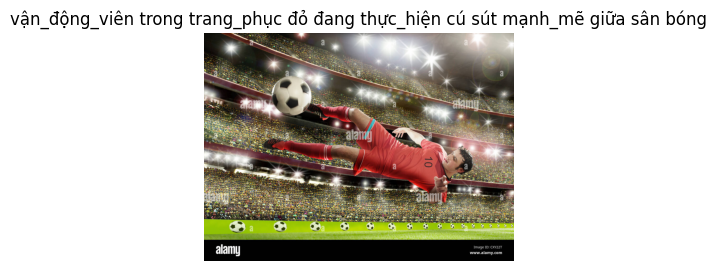

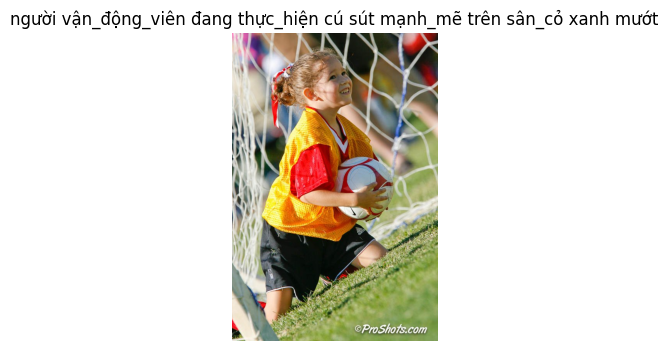

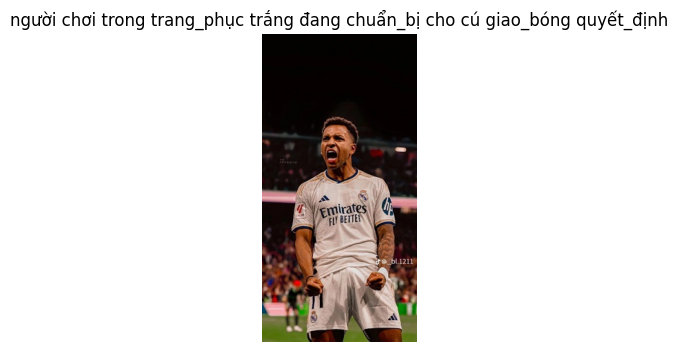

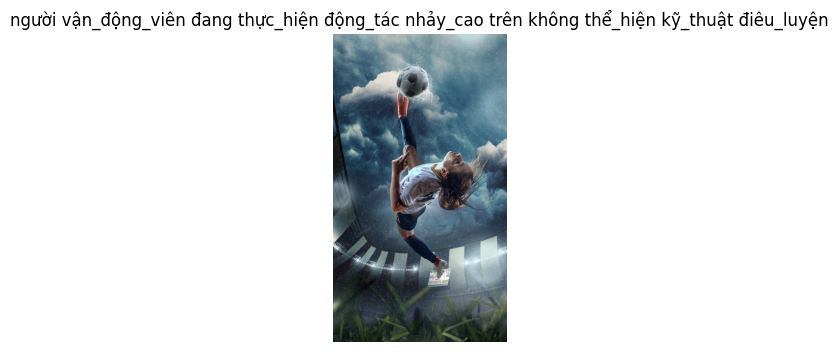

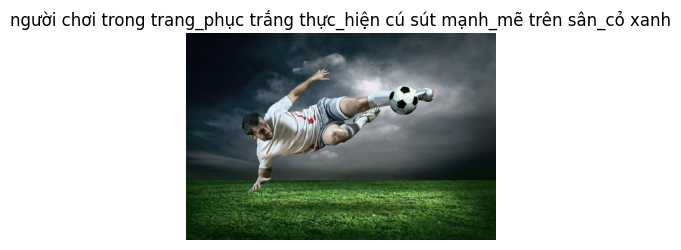

In [4]:
finetuned_model = run_pipeline(
    mode='finetune',
    vocab_path=vocab_path,
    train_imgs=train_imgs,
    train_caps=train_caps,
    model_name='t5-base',
    epochs=100,
    batch_size=16,
    lr=5e-5,
    val_imgs=val_imgs,
    val_caps=val_caps,
    test_imgs=test_imgs,
)

In [5]:
finetuned_model.generate_captions_for_folder(
    '/kaggle/input/caption-dataset/ic_dataset/test/images',
    output_dir="/kaggle/working/",
    output_name="finetune_cap_1.txt",
    max_length=30,
    num_beams=5
)

finetuned_model.generate_captions_for_folder(
    folder_path='/kaggle/input/capydata-caption/data/UIT-ViIC/dataset/test/images',
    output_dir="/kaggle/working/",
    output_name="finetune_cap_2.txt",
    max_length=30,
    num_beams=5
)

Saved captions to /kaggle/working/finetune_cap_1.txt
Saved captions to /kaggle/working/finetune_cap_2.txt


'/kaggle/working/finetune_cap_2.txt'

Train Epoch 1/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 1 Validation Loss: 2.4890
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 2.4890) --


Train Epoch 2/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 2 Validation Loss: 2.2645
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 2.2645) --


Train Epoch 3/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 3 Validation Loss: 1.9648
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.9648) --


Train Epoch 4/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 4 Validation Loss: 1.7545
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.7545) --


Train Epoch 5/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 5 Validation Loss: 1.6467
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.6467) --


Train Epoch 6/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 6 Validation Loss: 1.5885
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.5885) --


Train Epoch 7/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 7 Validation Loss: 1.5824
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.5824) --


Train Epoch 8/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 8 Validation Loss: 1.5127
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.5127) --


Train Epoch 9/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 9 Validation Loss: 1.4998
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4998) --


Train Epoch 10/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 10 Validation Loss: 1.4910
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4910) --


Train Epoch 11/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 11 Validation Loss: 1.4808
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4808) --


Train Epoch 12/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 12 Validation Loss: 1.4720
-- Saved best checkpoint at ./best_scratch_checkpoint.pt (loss: 1.4720) --


Train Epoch 13/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 13 Validation Loss: 1.4928
-- No improvement for 1 epoch(s) --


Train Epoch 14/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 14 Validation Loss: 1.4982
-- No improvement for 2 epoch(s) --


Train Epoch 15/100:   0%|          | 0/393 [00:00<?, ?it/s]

Epoch 15 Validation Loss: 1.5128
-- No improvement for 3 epoch(s) --
Early stopping after 3 epochs.
-- Test Random Samples --


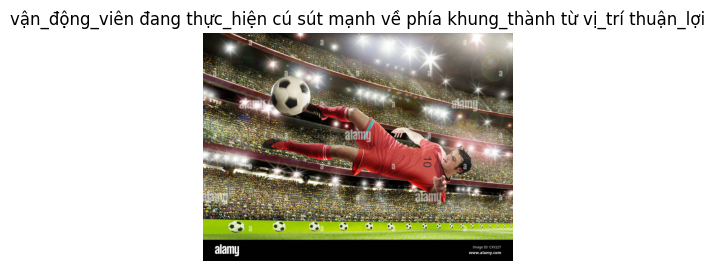

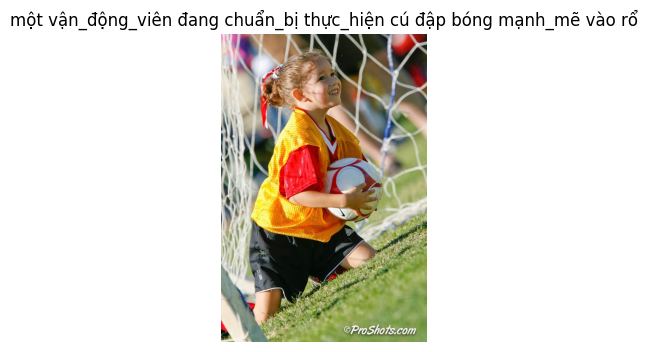

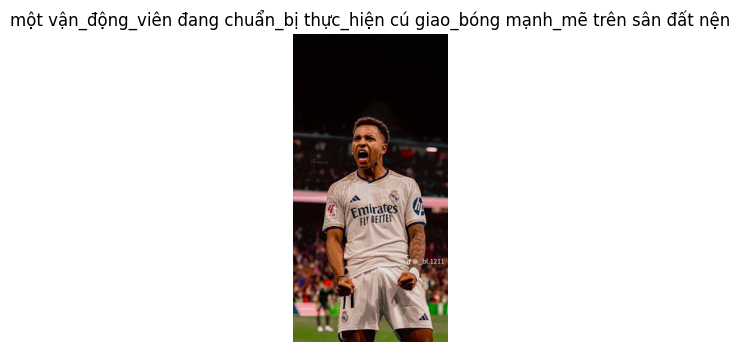

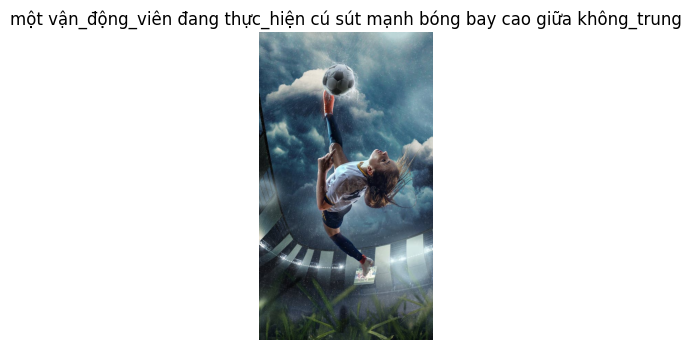

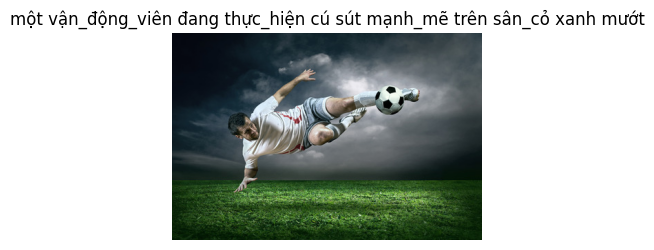

In [6]:
retrained_model = run_pipeline(
    mode='scratch',
    vocab_path=vocab_path,
    train_imgs=train_imgs,
    train_caps=train_caps,
    model_name='t5-base',
    epochs=100,
    batch_size=16,
    lr=5e-5,
    val_imgs=val_imgs,
    val_caps=val_caps,
    test_imgs=test_imgs,
)

In [7]:
retrained_model.generate_captions_for_folder(
    '/kaggle/input/caption-dataset/ic_dataset/test/images',
    output_dir="/kaggle/working/",
    output_name="retrain_cap_1.txt",
    max_length=30,
    num_beams=5
)

retrained_model.generate_captions_for_folder(
    folder_path='/kaggle/input/capydata-caption/data/UIT-ViIC/dataset/test/images',
    output_dir="/kaggle/working/",
    output_name="retrain_cap_2.txt",
    max_length=30,
    num_beams=5
)

Saved captions to /kaggle/working/retrain_cap_1.txt
Saved captions to /kaggle/working/retrain_cap_2.txt


'/kaggle/working/retrain_cap_2.txt'